In [ ]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from numpy import NaN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression

import os
import yfinance as yf
warnings.filterwarnings("ignore")


In [ ]:
def deepseek_absa_dataprocess(path):
  absa = pd.read_parquet(path)

  absa_date = absa[["date","tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa"]]
  absa_date = absa_date.groupby([absa_date['date'].dt.date], as_index=False).mean()

  absa_date['date'] = pd.to_datetime(absa_date['date'], format='%Y-%m-%d')

  # Extract only the date part (ignore the time)
  absa['date'] = absa['date'].dt.date
  absa_date['date'] = absa_date['date'].dt.date

  # Count the number of entries per day
  entries_per_day = absa.groupby('date').size()

  # Map the counts back to the original dataset
  absa['entries_per_day'] = absa['date'].map(entries_per_day)

  # Fill missing values with 0, if necessary
  absa_date['entries_per_day'] = absa['entries_per_day'].fillna(0)

  sentiment_columns = [
    'tanalysis_absa',
    'economy_absa',
    'regulation_absa',
    'technology_absa',
    'adoption_absa'
  ]

  # 2. Compute the average sentiment for each entry (row) by averaging across the sentiment columns
  absa_date['Average Sentiment'] = absa_date[sentiment_columns].mean(axis=1)
  absa_date['Average Sentiment'].fillna(0, inplace=True)
  absa_date['Sentiment_MA3'] = absa_date['Average Sentiment'].rolling(window=3, min_periods=1).mean()
  absa_date['Sentiment_MA7'] = absa_date['Average Sentiment'].rolling(window=7, min_periods=1).mean()
  absa_date['Sentiment_MA14'] = absa_date['Average Sentiment'].rolling(window=14, min_periods=1).mean()

  return absa_date


In [ ]:
def MutualInfo(df):
  X = df.drop(["target","date"], axis=1)
  y = df["target"]
  mi_scores = mutual_info_regression(X, y)
  mi_scores = pd.Series(mi_scores, index=X.columns)
  mi_scores.sort_values(ascending=False, inplace=True)
  print(mi_scores)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='daily'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'daily':
    df = concat_return(df, freq='daily')
    period_in_a_year = 365
  elif freq == 'hourly':
    df = concat_return(df, freq='hourly')
    period_in_a_year = 365 * 24
  elif freq == 'minute':
    df = concat_return(df, freq='minute')
    period_in_a_year = 365 * 24 * 60
  else:
    raise ValueError("Invalid freq argument. Must be 'daily', 'hourly', or 'minute'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Average Return & Sharpe ------------------
  # Calculate daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Overall Geometric Annual Return and Sharpe Ratio
  num_periods = len(df)
  # annual_return = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  annual_return = df['strategy_return'].mean() * period_in_a_year

  period_std = df['strategy_return'].std()
  annual_std = period_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return / annual_std

  print(f"Overall Annual Return: {round(annual_return*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  winning_trades = (df['strategy_return'] > 0).sum()
  losing_trades = (df['strategy_return'] < 0).sum()
  if losing_trades > 0:
    win_loss_ratio = winning_trades / losing_trades
  else:
    win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    # 'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return'] / yearly_data['yearly_std']
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='daily'):
  if freq == 'daily':
    file_path = "/content/drive/MyDrive/btcusd_daily_price.parquet"
  elif freq == 'hourly':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == 'minute':
    file_path = "../../bitcoin_historical_price/btcusd_minute_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'daily', 'hourly', or 'minute'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')
  return merged_df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as date, and 'signal' column
# for day freq trading only
# if 'return_forward_1d' is not present, it will be fetched automatically
def run_backtest(df):

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")
  if 'return_forward_1d' not in df.columns:
    df = concat_return(df)

  # ------------------ Average Return & Sharpe ------------------
  # Calculate daily returns
  df['strategy_return'] = df['signal'] * df['return_forward_1d']

  # Overall Annual Return and Sharpe Ratio
  num_days = len(df)
  # annual_return = (1 + df['strategy_return']).prod()**(365/num_days) - 1
  annual_return = df['strategy_return'].mean() * 365

  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(365)
  overall_sharpe = annual_return / annual_std

  print(f"Overall Annual Return: {round(annual_return*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # Count the number of winning vs losing days
  winning_trades = (df['strategy_return'] > 0).sum()
  losing_trades = (df['strategy_return'] < 0).sum()
  if losing_trades > 0:
    win_loss_ratio = winning_trades / losing_trades
  else:
    win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  print("Win/Loss Ratio:", round(win_loss_ratio, 2))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, return_forward_1d) / Var(return_forward_1d)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward_1d'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(return_forward_1d)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward_1d'].mean()

  # Annualize alpha
  # alpha_annualized = (1 + alpha_daily) ** 365 - 1
  alpha_annualized = alpha_daily * 365

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    # 'yearly_return': (1 + subdf['strategy_return']).prod()**(365/len(subdf)) - 1,
    'yearly_return': subdf['strategy_return'].mean() * 365,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(365),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward_1d'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward_1d'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward_1d'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward_1d'])[1,1]
      )
      * subdf['return_forward_1d'].mean()
    ) * 365
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return'] / yearly_data['yearly_std']
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward_1d']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()

def fetch_bitcoin_return_daily():
  price_df = yf.download("BTC-USD", interval="1d", start='2015-01-01', end='2025-01-02')
  price_df = price_df.xs('Close', level='Price', axis=1)
  price_df.columns = ['price']
  price_df['daily_return'] = price_df['price'].pct_change()
  price_df['return_forward_1d'] = price_df['daily_return'].shift(-1)
  price_df.drop(columns=['price', 'daily_return'], inplace=True)
  price_df = price_df[:-1]
  if len(price_df) == 0:
    print("Failed: fetch_bitcoin_return_daily")
    print("length of price dataframe = 0")
  price_df.to_parquet('btc_return_daily.parquet')

def concat_return(df):
  file_path = "btc_return_daily.parquet"
  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    fetch_bitcoin_return_daily()
    df_btc_return = pd.read_parquet(file_path)
  merged_df = pd.merge(df, df_btc_return, left_index=True, right_index=True, how='inner')
  return merged_df

In [ ]:
def generate_signals(df):
  df['date'] = pd.to_datetime(df['date'])

  # Generate signal column
  # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
  df['signal'] = df['Predicted Return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
  return df

In [ ]:
data = deepseek_absa_dataprocess("/workspaces/fyp/crypto_news/data/3b.cryptonews_absa.parquet")
btc_price = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price.parquet")

data = data [:-1]
data["date"] = pd.to_datetime(data["date"])
btc_price.index = pd.to_datetime(btc_price.index)


# Map btc_price["return_forward_1d"] to data["date"] to create the target column
data["target"] = data["date"].map(btc_price["return_forward"])

data["target"] = data["target"].apply(lambda x: 1 if x > 0.01 else (-1 if x < -0.01 else 0))
# Optional: Fill missing values in target with 0
data["target"].fillna(0, inplace=True)
data['entries_per_day'] = data['entries_per_day'].fillna(0)

data

,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
0,2021-01-01,0.635294,0.052941,-0.020588,0.014706,0.208824,43.0,0.178235,0.178235,0.178235,0.178235,0
1,2021-01-02,0.769767,0.011628,-0.006977,0.002326,0.069767,34.0,0.169302,0.173769,0.173769,0.173769,0
2,2021-01-03,0.697436,-0.007692,0.007692,0.020513,0.189744,34.0,0.181538,0.176359,0.176359,0.176359,-1
3,2021-01-04,0.071212,0.006061,-0.010606,0.027273,0.122727,34.0,0.043333,0.131391,0.143102,0.143102,1
4,2021-01-05,0.490769,0.061538,0.032308,0.038462,0.240000,34.0,0.172615,0.132496,0.149005,0.149005,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2024-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1457,2024-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1458,2024-12-29,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1459,2024-12-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
#Missing Target
target_col = "target"
data["date"] = pd.to_datetime(data["date"]).dt.date

train_startdate = pd.to_datetime("2021-01-01").date()
train_enddate = pd.to_datetime("2022-12-31").date()

# Training: 2021-01-01 to 2022-12-31
train_data = data[(data['date'] >= train_startdate) & (data['date'] <= train_enddate)]

val_startdate = pd.to_datetime("2023-01-01").date()
val_enddate = pd.to_datetime("2023-12-31").date()

# Validation: 2023-01-01 to 2023-12-31
validation_data = data[(data['date'] >= val_startdate) & (data['date'] <= val_enddate)]

test_startdate = pd.to_datetime("2024-01-01").date()
test_enddate = pd.to_datetime("2024-12-31").date()

# Test: 2024-01-01 to 2024-12-31
test_data = data[(data['date'] >= test_startdate) & (data['date'] <= test_enddate)]

features = ["tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa","cybersecurity_absa","entries_per_day", "Average Sentiment", "Sentiment_MA3", "Sentiment_MA7", "Sentiment_MA14"]
target_col = 'target'

test_data

,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
1095,2024-01-01,-0.054651,-0.009302,0.043023,0.011628,0.239535,40.0,0.046047,0.092759,0.134411,0.152487,0
1096,2024-01-02,0.076444,0.014667,0.113778,0.028000,0.343556,40.0,0.115289,0.095189,0.139428,0.148765,0
1097,2024-01-03,0.020532,-0.003422,0.028517,0.017490,0.228897,40.0,0.058403,0.073246,0.118886,0.144887,0
1098,2024-01-04,0.077626,-0.004566,0.005023,0.057078,0.398174,40.0,0.106667,0.093453,0.095098,0.140280,0
1099,2024-01-05,0.006557,-0.003825,0.068852,0.057377,0.298907,40.0,0.085574,0.083548,0.092030,0.131789,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2024-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1457,2024-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1458,2024-12-29,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0
1459,2024-12-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
nan_counts_before = data.isna().sum()
print(nan_counts_before)

date                 0
tanalysis_absa       0
economy_absa         0
regulation_absa      0
technology_absa      0
adoption_absa        0
entries_per_day      0
Average Sentiment    0
Sentiment_MA3        0
Sentiment_MA7        0
Sentiment_MA14       0
target               0
dtype: int64


In [ ]:

MutualInfo(data)

entries_per_day      0.034857
Sentiment_MA3        0.013397
economy_absa         0.010246
regulation_absa      0.003569
tanalysis_absa       0.000000
technology_absa      0.000000
adoption_absa        0.000000
Average Sentiment    0.000000
Sentiment_MA7        0.000000
Sentiment_MA14       0.000000
dtype: float64


In [ ]:
feature_cols =["tanalysis_absa","economy_absa","regulation_absa"
, "Sentiment_MA7", "Sentiment_MA14"]
target_col = "target"

X_train = train_data[feature_cols]
y_train = train_data[target_col]

# Validation Data
X_val = validation_data[feature_cols]
y_val = validation_data[target_col]

# Test Data
X_test = test_data[feature_cols]
y_test = test_data[target_col]



In [ ]:
nan_counts_before = data.isna().sum()
print(nan_counts_before)

date                 0
tanalysis_absa       0
economy_absa         0
regulation_absa      0
technology_absa      0
adoption_absa        0
entries_per_day      0
Average Sentiment    0
Sentiment_MA3        0
Sentiment_MA7        0
Sentiment_MA14       0
target               0
dtype: int64


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

X_train_smoothed = X_train.copy()
numeric_columns = X_train_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_train_smoothed[f'{col}_ewm'] = X_train_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()
X_train_smoothed

rf.fit(X_train_smoothed, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
#Evaluate Model by Validation

X_val_smoothed = X_val.copy()
numeric_columns = X_val_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_val_smoothed[f'{col}_ewm'] = X_val_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()

y_pred_val = rf.predict(X_val_smoothed)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Validation Set Metrics:
MSE: 0.106849
R-squared: -0.8632


In [ ]:
# Example: Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 5, 10, 15,20],
    'min_samples_split': [2, 5, 10, 15, 20],

}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf_reg = grid_search.best_estimator_
best_rf_reg.fit(X_train_smoothed, y_train)


In [ ]:
importances = best_rf_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_smoothed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


               Feature  Importance
3        Sentiment_MA7    0.158380
6     economy_absa_ewm    0.153903
1         economy_absa    0.123745
8    Sentiment_MA7_ewm    0.110899
2      regulation_absa    0.102834
7  regulation_absa_ewm    0.099353
9   Sentiment_MA14_ewm    0.077577
5   tanalysis_absa_ewm    0.069481
4       Sentiment_MA14    0.052220
0       tanalysis_absa    0.051607


In [ ]:
validation_data

,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
730,2023-01-01,0.188571,-0.060000,-0.091429,0.054286,0.071429,80.0,0.032571,0.071450,0.082406,0.074121,0
731,2023-01-02,0.321875,0.054688,0.059375,0.010938,0.198438,80.0,0.129063,0.086908,0.088406,0.075678,0
732,2023-01-03,0.236264,-0.013187,-0.056044,0.085714,0.150549,80.0,0.080659,0.080764,0.084175,0.074279,0
733,2023-01-04,0.302632,-0.046053,-0.030263,0.075000,0.076316,80.0,0.075526,0.095083,0.081351,0.075511,0
734,2023-01-05,0.277778,0.006667,-0.055556,0.042222,0.240000,80.0,0.102222,0.086136,0.085974,0.082944,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,0.244509,0.000578,0.174566,0.020809,0.570520,40.0,0.202197,0.124221,0.170887,0.153530,0
1091,2023-12-28,0.263636,0.007576,0.330303,0.039394,0.725000,40.0,0.273182,0.185184,0.185462,0.166569,0
1092,2023-12-29,0.014388,-0.002158,0.080576,0.075540,0.366906,40.0,0.107050,0.194143,0.171549,0.160251,0
1093,2023-12-30,0.103529,-0.009412,0.084706,0.008235,0.352941,40.0,0.108000,0.162744,0.150234,0.160761,0


In [ ]:
print(f"Index type: {validation_data.index.dtype}")

Index type: int64


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Overall Annual Return: -12.15%
Overall Annual Sharpe Ratio: -1.1444
Maximum Drawdown: -13.03 %
Win/Loss Ratio: 1.22
Alpha: -0.0607
Beta: -0.0567

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023      -0.121521     0.10619    -0.056678     -0.060683      -1.144375


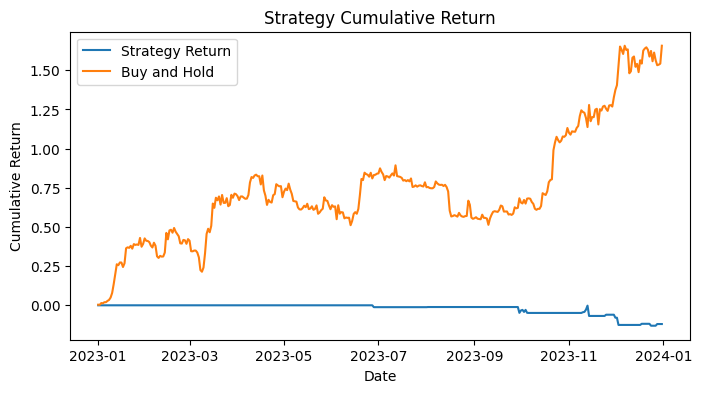

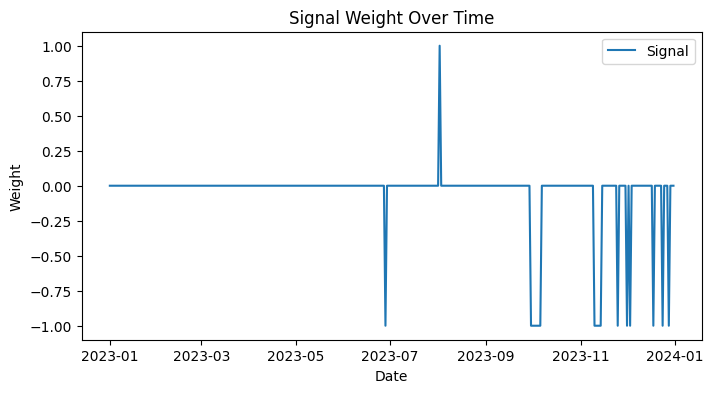

In [ ]:
temp = pd.DataFrame()
temp["date"] = validation_data["date"]
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

rfr_bt = temp
rfr_bt['date'] = pd.to_datetime(rfr_bt['date'])

rfr_bt.set_index('date', inplace=True)

run_backtest(rfr_bt)


# XGB

In [ ]:
xgb = XGBRegressor(random_state=42)


xgb.fit(X_train_smoothed, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
#Evaluate Model by Validation
y_pred_val = xgb.predict(X_val_smoothed)

mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')

Validation Set Metrics:
MSE: 0.141902
R-squared: -1.4745


In [ ]:
y_train

0      0
1      0
2     -1
3      1
4     -1
      ..
725    0
726    0
727    0
728    0
729    0
Name: target, Length: 730, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)


In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

xgb = XGBClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress
    n_jobs=-1  # Use all available CPU cores
)
grid_search.fit(X_train_smoothed, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)
best_xgb_reg = grid_search.best_estimator_


Fitting 3 folds for each of 972 candidates, totalling 2916 fits


KeyboardInterrupt: 

In [ ]:
len(y_pred_val)

In [ ]:
temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = validation_data["date"]
x = x.reset_index(drop=True)
temp['date'] = x['date']

xgb_bt = temp


xgb_bt.set_index('date', inplace=True)
xgb_bt

In [ ]:
temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = validation_data["date"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

xgb_bt = temp


xgb_bt.set_index('date', inplace=True)


run_backtest(xgb_bt)



In [ ]:
importances = best_xgb_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_smoothed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


# Testing

# RFR

In [ ]:
model = best_rf_reg

X_test_smoothed = X_test.copy()
numeric_columns = X_test_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_test_smoothed[f'{col}_ewm'] = X_test_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()

y_pred_test = model.predict(X_test_smoothed)


temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = test_data["date"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

rfr_bt_test = temp


rfr_bt_test.set_index('date', inplace=True)


run_backtest(rfr_bt_test)


In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_startdate = pd.to_datetime("2024-01-01").date()
test_enddate = pd.to_datetime("2024-12-31").date()

data = test_data[(test_data['date'] >= test_startdate) & (test_data['date'] <= test_enddate)]
# btc_price["Open Time"] = pd.to_datetime(btc_price["Open Time"]).dt.date

btc = btc_price.loc["2024-01-01":"2024-12-31"]


x = pd.DataFrame()

x['signal'] = btc["return_forward_1d"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# print(x.shape[0])
# print(data.shape[0])

# Assuming df1 and df2 are your two dataframes with a 'signal' column
# Ensure both dataframes are aligned (e.g., same index and sorted by date)
assert x.shape[0] == data.shape[0], "Dataframes must have the same number of rows"

# Extract the signal columns from both dataframes
true_signals = x['signal']  # Ground truth signals
predicted_signals = rfr_bt_test['signal']  # Predicted signals

# Calculate precision, recall, and F1 score
precision = precision_score(true_signals, predicted_signals, average='binary', pos_label=1)
recall = recall_score(true_signals, predicted_signals, average='binary', pos_label=1)
f1 = f1_score(true_signals, predicted_signals, average='binary', pos_label=1)

# Display the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Test Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


# XGB

In [ ]:
model = best_xgb_reg
y_pred_test = model.predict(X_test_smoothed)



temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = test_data["date"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

xgb_bt_test = temp


xgb_bt_test.set_index('date', inplace=True)


run_backtest(xgb_bt_test)

In [ ]:
test_data


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_startdate = pd.to_datetime("2024-01-01").date()
test_enddate = pd.to_datetime("2024-12-31").date()

data = test_data[(test_data['date'] >= test_startdate) & (test_data['date'] <= test_enddate)]
btc = btc_price.loc["2024-01-01":"2024-12-31"]


x = pd.DataFrame()

# x['signal'] = btc["return_forward_1d"]

x['signal'] = btc["return_forward_1d"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# print(x.shape[0])
# print(data.shape[0])

# Assuming df1 and df2 are your two dataframes with a 'signal' column
# Ensure both dataframes are aligned (e.g., same index and sorted by date)
assert x.shape[0] == data.shape[0], "Dataframes must have the same number of rows"

# Extract the signal columns from both dataframes
true_signals = x['signal']  # Ground truth signals
predicted_signals = xgb_bt_test['signal']  # Predicted signals

# Calculate precision, recall, and F1 score
precision = precision_score(true_signals, predicted_signals, average='binary', pos_label=1)
recall = recall_score(true_signals, predicted_signals, average='binary', pos_label=1)
f1 = f1_score(true_signals, predicted_signals, average='binary', pos_label=1)

# Display the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Test Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


# END

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression


In [ ]:
log_reg = LogisticRegression(random_state=42)

# Step 4: Train the model on the training data
log_reg.fit(X_train_smoothed, y_train)




LogisticRegression(random_state=42)

In [ ]:
#Evaluate Model by Validation
y_pred_val = log_reg.predict(X_val_smoothed)



In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Step 3: Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
    'C': [0.01, 0.1, 1, 10, 100],                # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],             # Optimization solvers
    'l1_ratio': [0.5, 0.7, 0.9, None]            # Only used with 'elasticnet'
}

# Step 4: Perform Grid Search using GridSearchCV
grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           cv=5,                   # 5-fold cross-validation
                           scoring='accuracy',     # Scoring metric
                           verbose=2,              # Show progress
                           n_jobs=-1)              # Use all available CPU cores

# Fit the model
grid_search.fit(X_train, y_train)

# Step 5: Retrieve the best parameters and evaluate the model
print("Best Parameters:", grid_search.best_params_)



Fitting 5 folds for each of 160 candidates, totalling 800 fits


/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty i

[CV] END .C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty i

[CV] END ......C=0.01, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....C=0.01, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END .C=0.01, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....C=0.01, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END .C=0.01, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, l1_ra

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parame

[CV] END ....C=0.01, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END ...C=0.01, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ...C=0.01, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ....C=0.01, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s
[CV] END ..C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.1, l1_ratio=0.5

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.

[CV] END C=0.1, l1_ratio=0.7, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .....C=0.1, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END C=0.1, l1_ratio=0.7, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.1, l1_ratio=0.7, penalty=None, solver=liblinear; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.1, l1_ratio=0.7, penalty=None, solver=liblinear; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.1, l1_ratio=0.7, penalty=None, solver=liblinear; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.1, l1_ratio=0.7, penalty=None, solver=liblinear; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...C=0.01, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END .......C=0.1, l1_r

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty


[CV] END C=0.1, l1_ratio=0.9, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.1, l1_ratio=0.9, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .C=0.1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.1, l1_ratio=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.1, l1_ratio=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.1, l1_ratio=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.1, l1_ratio=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......C=0.1, l1_ratio=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.1, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.1, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.1, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.1, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.1, l1_ratio

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty

[CV] END .......C=0.1, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..C=0.1, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..C=0.1, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......C=0.1, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..C=0.1, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=0.1, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ..C=0.1, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....C=1, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s[CV] END .....C=0.1, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s

[CV] END ....C=1, l1_ratio=0

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penal

[CV] END .....C=0.1, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s
[CV] END .C=0.1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .......C=1, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END C=1, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. 

[CV] END .........C=1, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END .......C=1, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END .........C=1, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=1, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, l1_rat

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penal

[CV] END ........C=1, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ........C=1, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ........C=1, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=1, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END .......C=1, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s[CV] END ......C=1, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s

[CV] END ...C=10, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......C=1, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ........C=10, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=1, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END ....C=1, l1_ratio=0

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty

[CV] END ........C=10, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=1, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....C=1, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....C=1, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.0s
[CV

one)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio 

[CV] END .......C=1, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s
[CV] END ...C=10, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ........C=10, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...C=1, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'

[CV] END ........C=10, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=10, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END ........C=10, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.1s
[CV] END ........C=10, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.1s
[CV] END ......C=10, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.2s
[CV] END ...C=10, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........C=10, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.2s
[CV] END ...C=10, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........C=10, l1_ra

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'

[CV] END ...C=10, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........C=10, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........C=10, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ........C=10, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END ........C=10, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parame

[CV] END C=10, l1_ratio=0.9, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END .C=10, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END .C=10, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END ......C=10, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END .C=10, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END .C=10, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s[CV] END .C=10, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s

[CV] END ...C=10, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=10, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END ...C=10, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.9, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

[CV] END .....C=10, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ........C=10, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.0s
[CV] END .......C=10, l1_ratio=None, penalty=l1, solver=saga; total time=   0.1s
[CV] END ......C=10, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s
[CV] END .....C=10, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ........C=10, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.0s
[CV] END .......C=10, l1_ratio=None, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..C=10, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=10, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=10, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=10, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........C=10, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..C=10, l1_ratio=No

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio paramete

[CV] END .......C=10, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ........C=10, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.1s
[CV] END .......C=10, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=10, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......C=10, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....C=10, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ......C=10, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s
[CV] END .......C=100, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, l1_ratio=0.5

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty i

[CV] END .......C=100, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=100, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=100, l1_ratio=0.5, penalty=None, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.5, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.5, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.5, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.5, penalty=None, solver=liblinear; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, l1_ratio=0.5, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.5, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100,

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warning

[CV] END C=100, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END .......C=100, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=100, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END C=100, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END .....C=100, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END C=100, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.5, penalty=l1, solver=saga; total time=   

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'

[CV] END .......C=100, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=100, l1_ratio=0.5, penalty=None, solver=saga; total time=   0.1s
[CV] END ..C=100, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END ..C=100, l1_ratio=0.7, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=100, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=saga; total time=   0.1s


/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'

[CV] END .......C=100, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=100, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END .....C=100, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END .......C=100, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=100, l1_ratio=0.7, penalty=None, solver=saga; total time=   0.1s
[CV] END ..C=100, l1_ratio=0.9, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.9, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=saga; total time=   0.1s


/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'

[CV] END ..C=100, l1_ratio=0.9, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.9, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.9, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.7, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=100, l1_ratio=0.5, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..C=100, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END ..C=100, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.7, penalty=None, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.9, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty i

[CV] END .......C=100, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..C=100, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=100, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..C=100, l1_ratio=0.7, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.3s
[CV] END .......C=100, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......C=100, l1_ratio=0.9, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.9, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, 

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END .......C=100, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......C=100, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=100, l1_ratio=0.9, penalty=elasticnet, solver=saga; total time=   0.3s
[CV] END .......C=100, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=100, l1_ratio=0.7, penalty=l2, solver=saga; total time=   0.0s
[CV] END .C=100, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.9, penalty=elasticnet, solver=saga; total time=   0.2s


/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty

[CV] END .......C=100, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=100, l1_ratio=0.9, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=100, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END ......C=100, l1_ratio=None, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=100, l1_ratio=0.9, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.9, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END .....C=100, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s
[CV] END .......C=100, l1_ratio=0.9, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=100, l1_ratio=None, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=100, l1_ra

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty

[CV] END ......C=100, l1_ratio=None, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=100, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s
[CV] END ....C=100, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ....C=100, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END .....C=100, l1_ratio=0.9, penalty=None, solver=saga; total time=   0.1s
[CV] END .C=100, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=100, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END .C=100, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=100, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=100, l1_ratio=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=100, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ....C=100, l1_ratio=None, penalty=None, solver=saga; total time=   0.1s
[CV] END ......C=100, l1_rat

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/codesp

[CV] END ......C=100, l1_ratio=None, penalty=l1, solver=saga; total time=   0.1s
[CV] END .C=100, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=100, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=100, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=100, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=100, l1_ratio=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......C=100, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......C=100, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......C=100, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......C=100, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......C=100, l1_ratio=None, penalty=l2, solver=saga; total time=   0.0s
Best Parameters: {'C': 0.01, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
x['date'] = test_data["date"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

log_reg_test = temp


log_reg_test.set_index('date', inplace=True)


run_backtest(log_reg_test)

ValueError: feature_names mismatch: ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'Sentiment_MA7', 'Sentiment_MA14', 'tanalysis_absa_ewm', 'economy_absa_ewm', 'regulation_absa_ewm', 'Sentiment_MA7_ewm', 'Sentiment_MA14_ewm'] ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'Sentiment_MA7', 'Sentiment_MA14']
expected Sentiment_MA7_ewm, tanalysis_absa_ewm, economy_absa_ewm, Sentiment_MA14_ewm, regulation_absa_ewm in input data

In [ ]:
log_reg_test

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_startdate = pd.to_datetime("2024-01-01").date()
test_enddate = pd.to_datetime("2024-12-31").date()

data = test_data[(test_data['date'] >= test_startdate) & (test_data['date'] <= test_enddate)]
btc = btc_price.loc["2024-01-01":"2024-12-31"]


x = pd.DataFrame()

# x['signal'] = btc["return_forward_1d"]

x['signal'] = btc["return_forward_1d"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# print(x.shape[0])
# print(data.shape[0])

# Assuming df1 and df2 are your two dataframes with a 'signal' column
# Ensure both dataframes are aligned (e.g., same index and sorted by date)
assert x.shape[0] == data.shape[0], "Dataframes must have the same number of rows"

# Extract the signal columns from both dataframes
true_signals = x['signal']  # Ground truth signals
predicted_signals = log_reg_test['signal']  # Predicted signals

# Calculate precision, recall, and F1 score
precision = precision_score(true_signals, predicted_signals, average='micro', pos_label=1)
recall = recall_score(true_signals, predicted_signals, average='micro', pos_label=1)
f1 = f1_score(true_signals, predicted_signals, average='micro', pos_label=1)

# Display the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
